# Сбор данных

In [32]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
conn = psycopg2.connect(
 host="158.160.52.106",
 port=5432,
 database="postgres",
 user="student",
 password="JvLda93aA",
)

In [33]:
game_df = pd.read_sql("SELECT * FROM msu_analytics.game", conn)
client_df = pd.read_sql("SELECT * FROM msu_analytics.client", conn)
application_df = pd.read_sql("SELECT * FROM msu_analytics.application", conn)
account_df = pd.read_sql("SELECT * FROM msu_analytics.account", conn)
client_df.head(5)

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

,client_rk,first_name,last_name,phone_num,visit_dttm
0,6,Антонин,Юдин,+79024915261,2022-11-29 08:17:46.830477
1,70,Любовь,Орлова,+79661781045,2023-01-08 23:22:20.265566
2,198,Ольга,Терентьева,+79512646441,2022-11-19 21:34:25.018290
3,214,Ростислав,Савин,+79652972184,2022-09-27 06:26:27.410662
4,257,Феликс,Калинин,+79009059445,2022-10-29 15:40:48.805064


In [34]:
account_df.head(5)

,account_rk,client_rk,registration_dttm,login,password,email
0,3,3231,2023-01-14 10:58:05.929217,mmolcanov,upv0iIrxoSp,mmolcanov41@example.net
1,19,1112,2023-01-21 01:48:29.456384,sava.cernova,RfEPgtqq68,sava.cernova92@example.net
2,35,2639,2022-12-16 02:28:21.191349,dmitrij12,xaSjqx0G,dmitrij1239@example.org
3,51,180,2023-01-19 12:49:07.145068,zahar.emelanova,mV5KBcZz8,zahar.emelanova10@example.com
4,67,2590,2022-09-01 15:55:02.428356,orlov.fedor,1oJeSkqL,orlov.fedor14@example.org


In [35]:
application_df.head(5)

,application_rk,account_rk,game_rk,application_dttm
0,135,486,455,2022-11-25 00:08:02.487626
1,167,615,19,2022-09-13 23:42:13.458572
2,247,796,302,2023-01-17 17:33:26.876636
3,300,676,304,2022-11-06 22:17:14.439920
4,476,578,441,2022-09-20 07:18:50.422621


In [36]:
game_df.head(5)

,game_rk,quest_rk,employee_rk,game_dttm,price,game_flg,finish_flg,time
0,15,13,11,2022-11-17 02:13:10.970497,2701.92,0,0,00:00:00
1,79,31,3,2022-12-02 19:53:58.107147,1399.31,0,0,00:00:00
2,111,21,14,2022-11-22 09:31:30.506502,1349.32,0,0,00:00:00
3,127,15,7,2022-12-27 01:59:28.540922,1557.79,0,0,00:00:00
4,143,22,8,2022-12-30 10:39:51.834731,1880.07,0,0,00:00:00


In [37]:
print(client_df.shape[0] == client_df['phone_num'].unique().shape[0])
print(account_df.shape[0] == account_df['client_rk'].unique().shape[0])
print(application_df.shape[0] == application_df['account_rk'].unique().shape[0])
print(application_df.shape[0] == application_df['game_rk'].unique().shape[0])
print(game_df.shape)
print(application_df["account_rk"].nunique())

True
True
False
False
(456, 8)
293


In [38]:
application_df.groupby('game_rk').count().head(5)

,application_rk,account_rk,application_dttm
game_rk,,,
1,3,3,3
2,1,1,1
3,3,3,3
5,3,3,3
6,2,2,2


In [39]:
week_colors_list = ['#33CDC7', '#42E73A', '#FF9540', '#FE3F44']
month_colors_list = ['#7C45D6', '#35D4A0', '#FF8040', '#FFE940']

Из условия не очевидно, требуется ли привзяывать воронку к дате первого посещения пользователем сайта. В первом случае рассмотрим воронку, когда все остальные эвенты првязываются к дате посещения пользователем сайта. Во втором рассмотрим просто группировку по неделям и месяцам на каждом этапе без привязки. Также для недель и месяцев посчитаем конверсию как от первого числа (оличество посещений), так и от предыдущего (посещения - в создания аккаунта, создания аккаунта - в заявки и заявки - в игры).

# Первый вариант

In [54]:
#Cначала мерджим таблицу клиентов с их аккаунтами
conversion_df = client_df.filter(['visit_dttm', 'client_rk'])
conversion_df = pd.merge(conversion_df, account_df.filter(['client_rk', 'account_rk']), on='client_rk', how='left')

#Nеперь нужно смерджить заявки и игры по этим заявкам. Это нужно сделать, 
#чтобы при мердже заявок и аккаунтов мы не потеряли посещенные игры (от одного аккаунта может быть несколько заявок)
finish_applications_df = pd.merge(application_df.filter(['account_rk', 'game_rk']), game_df.filter(['game_rk', 'game_flg']), on='game_rk', how='left')
finish_applications_df = finish_applications_df.loc[finish_applications_df.groupby('account_rk')['game_flg'].idxmax()]

#Мерджим и переименовываем итоговую таблицу
conversion_df = pd.merge(conversion_df, finish_applications_df, on='account_rk', how='left')
conversion_df = conversion_df.rename({'client_rk' : 'clients', 'account_rk' : 'accounts', 'game_rk' : 'applications', 'game_flg' : 'games'}, axis = 1)

week_conversion_df = conversion_df.groupby(pd.Grouper(key = 'visit_dttm', freq = 'W'))\
  .agg({'clients' : 'count', 'accounts' : 'count', 'applications' : 'count', 'games' : 'sum'})

week_conversion_df['games'] = week_conversion_df['games'].astype('int')
week_conversion_df

,clients,accounts,applications,games
visit_dttm,,,,
2022-09-04,111,32,7,5
2022-09-11,184,31,6,5
2022-09-18,167,43,16,8
2022-09-25,181,45,12,11
2022-10-02,195,59,17,17
2022-10-09,204,58,18,15
2022-10-16,190,44,13,13
2022-10-23,171,41,12,10
2022-10-30,189,48,15,11


In [55]:
month_conversion_df = conversion_df.groupby(pd.Grouper(key = 'visit_dttm', freq = 'M'))\
  .agg({'clients' : 'count', 'accounts' : 'count', 'applications' : 'count', 'games' : 'sum'})

month_conversion_df['games'] = month_conversion_df['games'].astype('int')
month_conversion_df

,clients,accounts,applications,games
visit_dttm,,,,
2022-09-30,778,190,51,39
2022-10-31,843,217,65,56
2022-11-30,786,200,56,50
2022-12-31,805,196,57,33
2023-01-31,852,213,64,20
2023-02-28,32,8,0,0


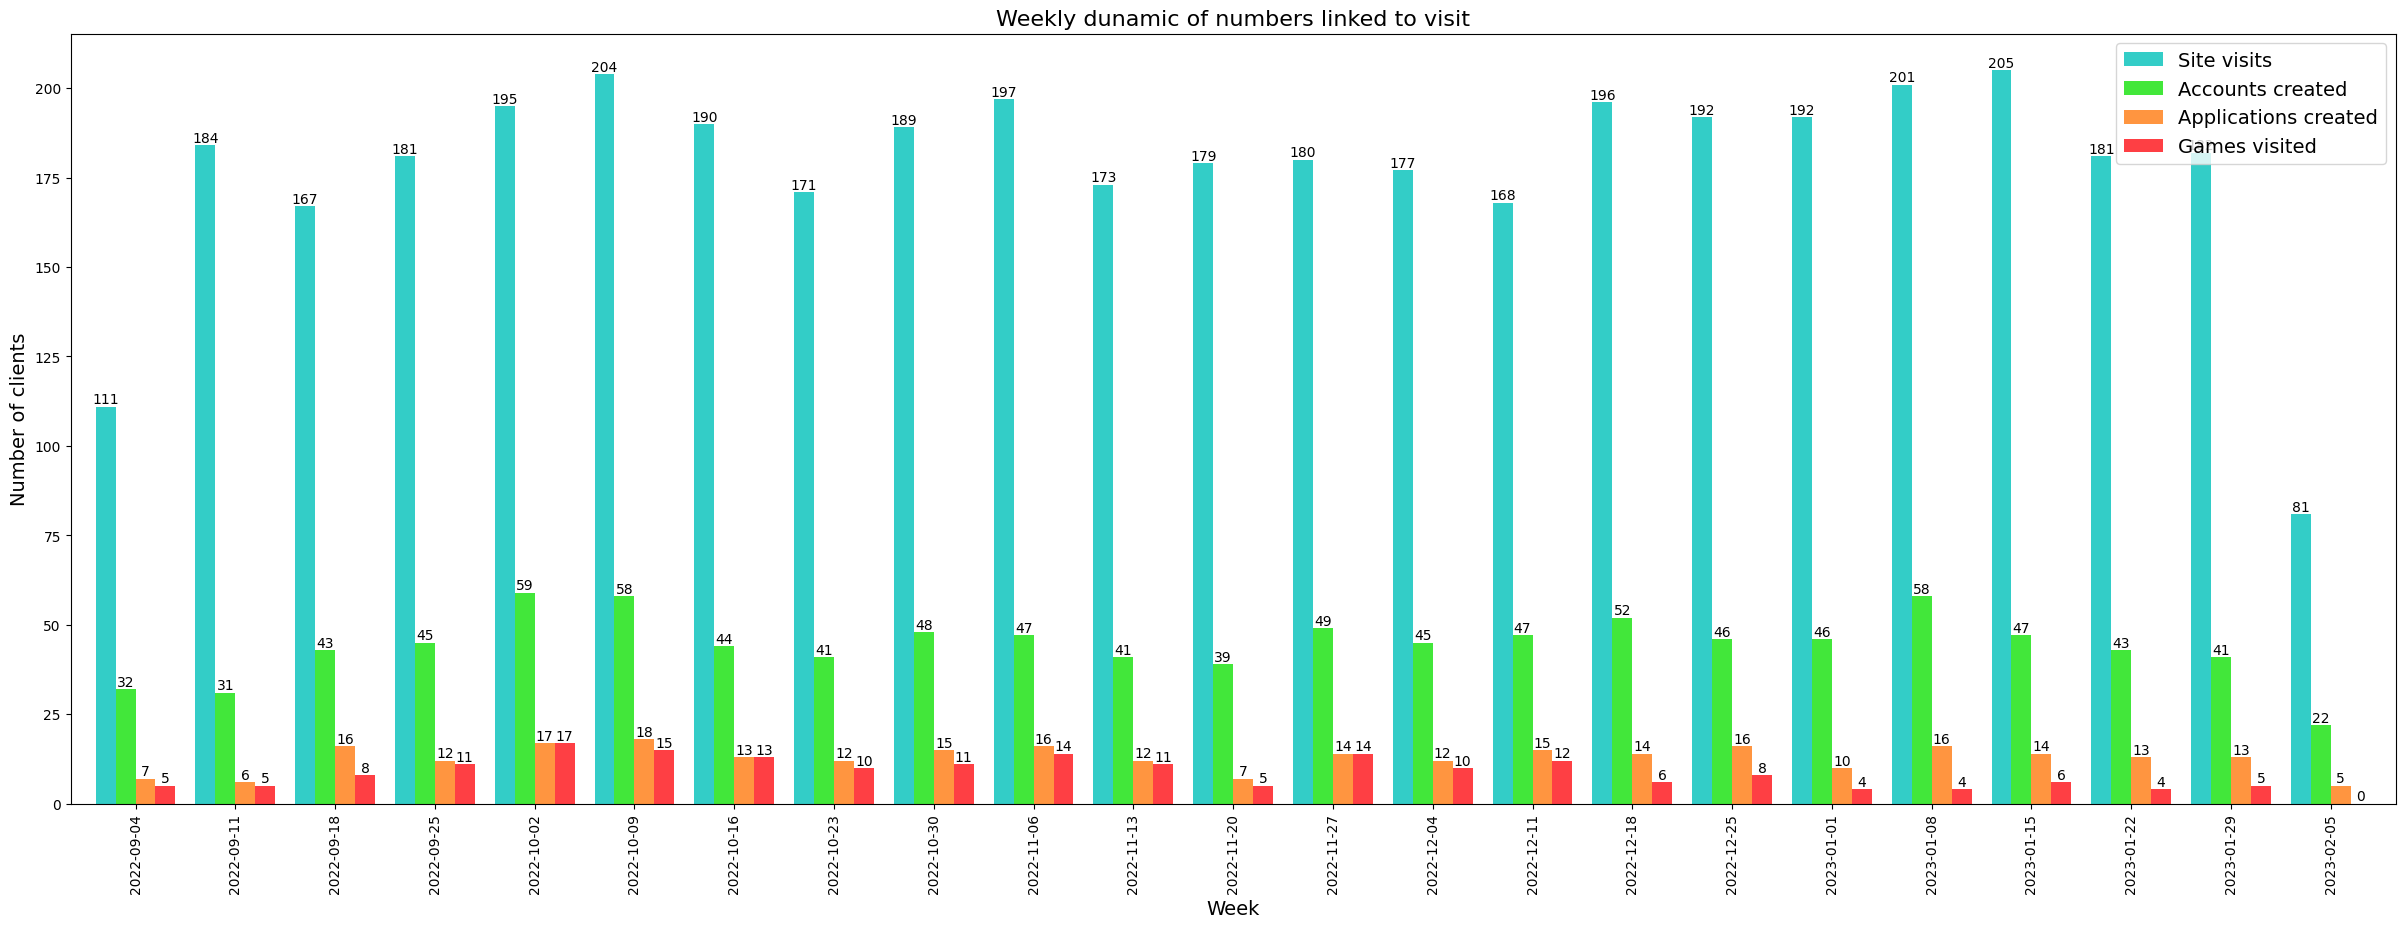

In [56]:
week_conversion_plot = week_conversion_df.plot(kind='bar', figsize=(30, 10), color = week_colors_list, width = 0.8)
week_conversion_plot.set_xticklabels([i.strftime('%Y-%m-%d') for i in week_conversion_df.index])
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Weekly dunamic of numbers linked to visit", fontsize= 16)
plt.legend(['Site visits', 'Accounts created', 'Applications created', 'Games visited'], fontsize=14)
plt.xticks(rotation=90)


for cont in week_conversion_plot.containers:
    week_conversion_plot.bar_label(cont, label_type='edge', fontsize=10, labels=[f'{j.get_height()}' for j in cont])
plt.show()

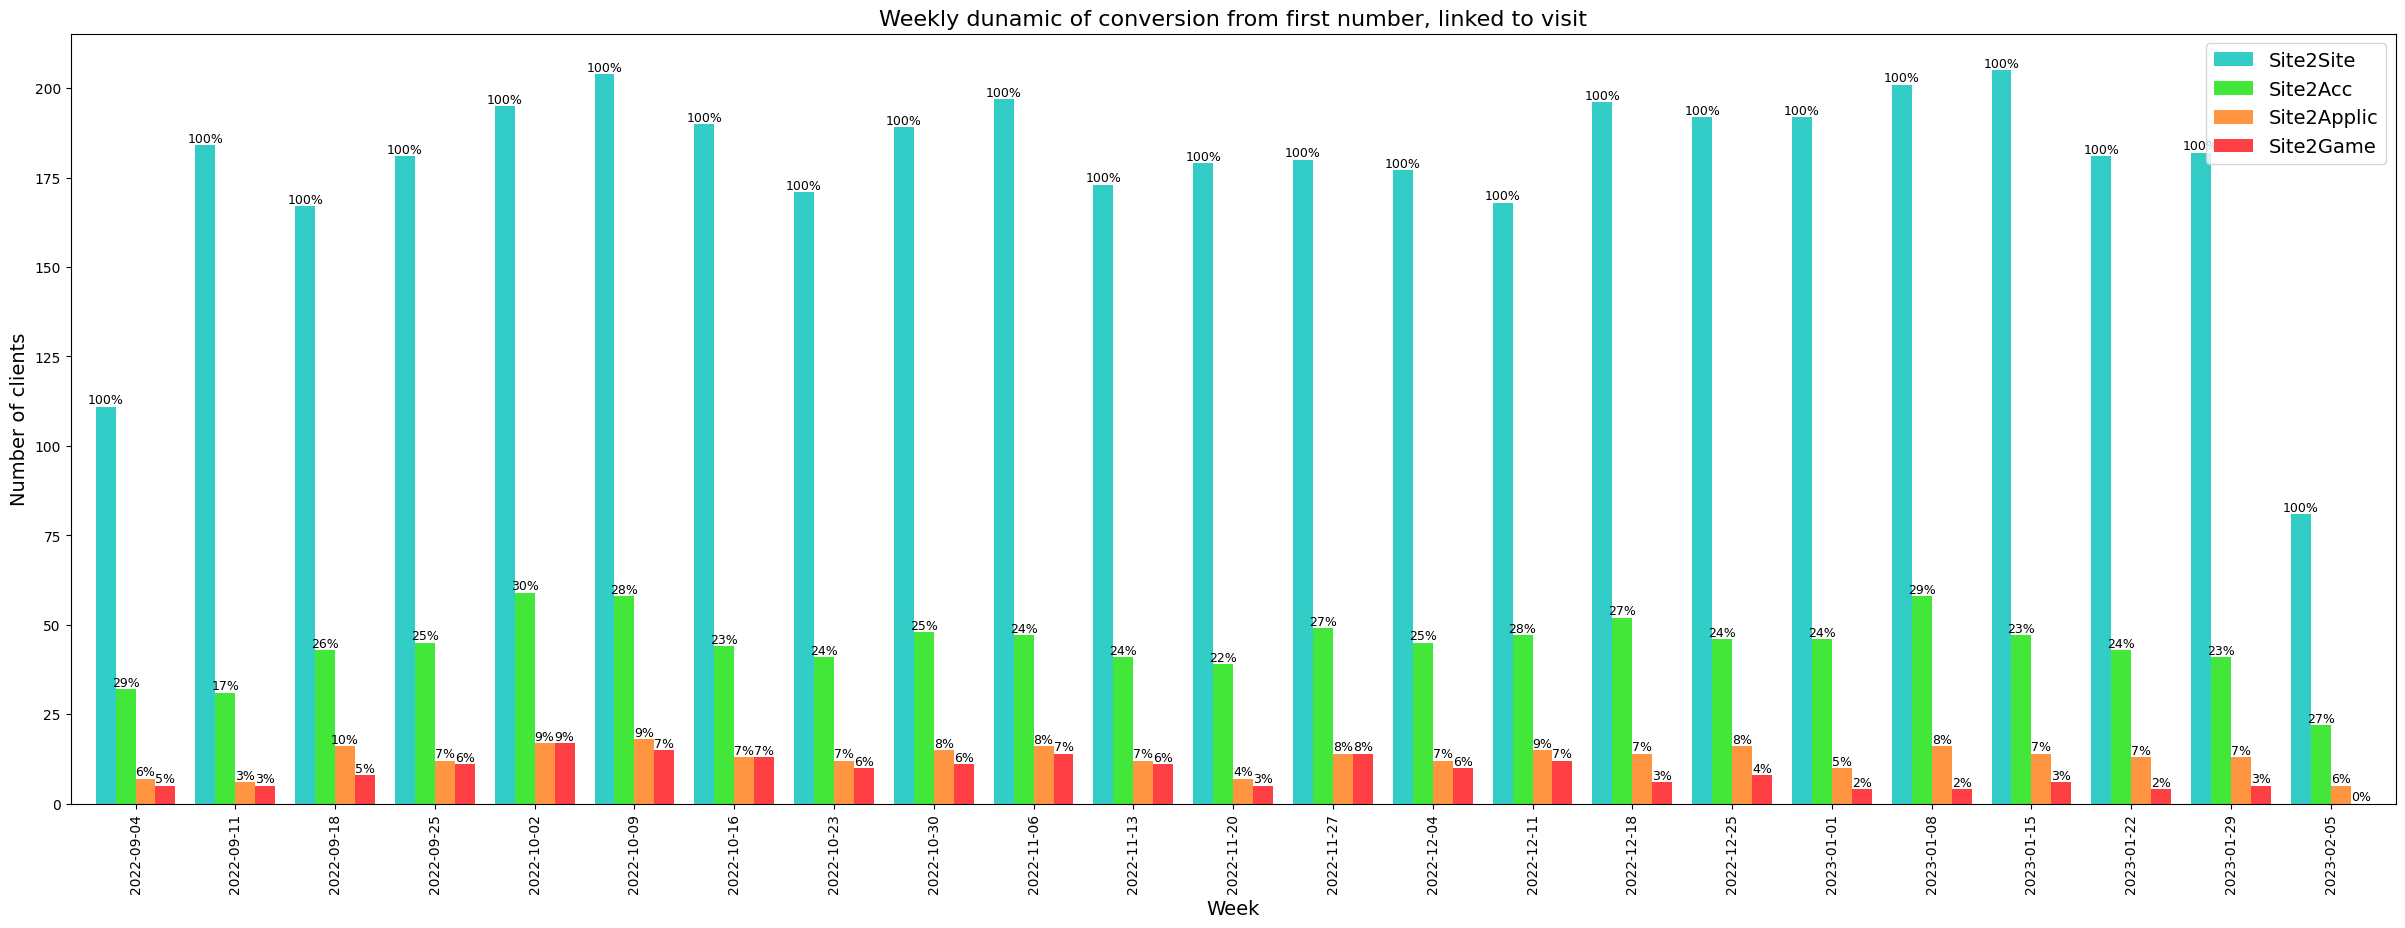

In [57]:
week_conversion_plot = week_conversion_df.plot(kind='bar', figsize=(30, 10), color = week_colors_list, width = 0.8)
week_conversion_plot.set_xticklabels([i.strftime('%Y-%m-%d') for i in week_conversion_df.index])
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Weekly dunamic of conversion from first number, linked to visit", fontsize= 16)
plt.legend(['Site2Site', 'Site2Acc', 'Site2Applic', 'Site2Game'], fontsize=14)
plt.xticks(rotation=90)

heights = [i.get_height() for i in week_conversion_plot.containers[0]]
for cont in week_conversion_plot.containers:
  week_conversion_plot.bar_label(cont, label_type='edge', fontsize=9,
                                 labels=[f'{cont[j].get_height() / heights[j]:.0%}' for j in range(len(cont))])
plt.show()

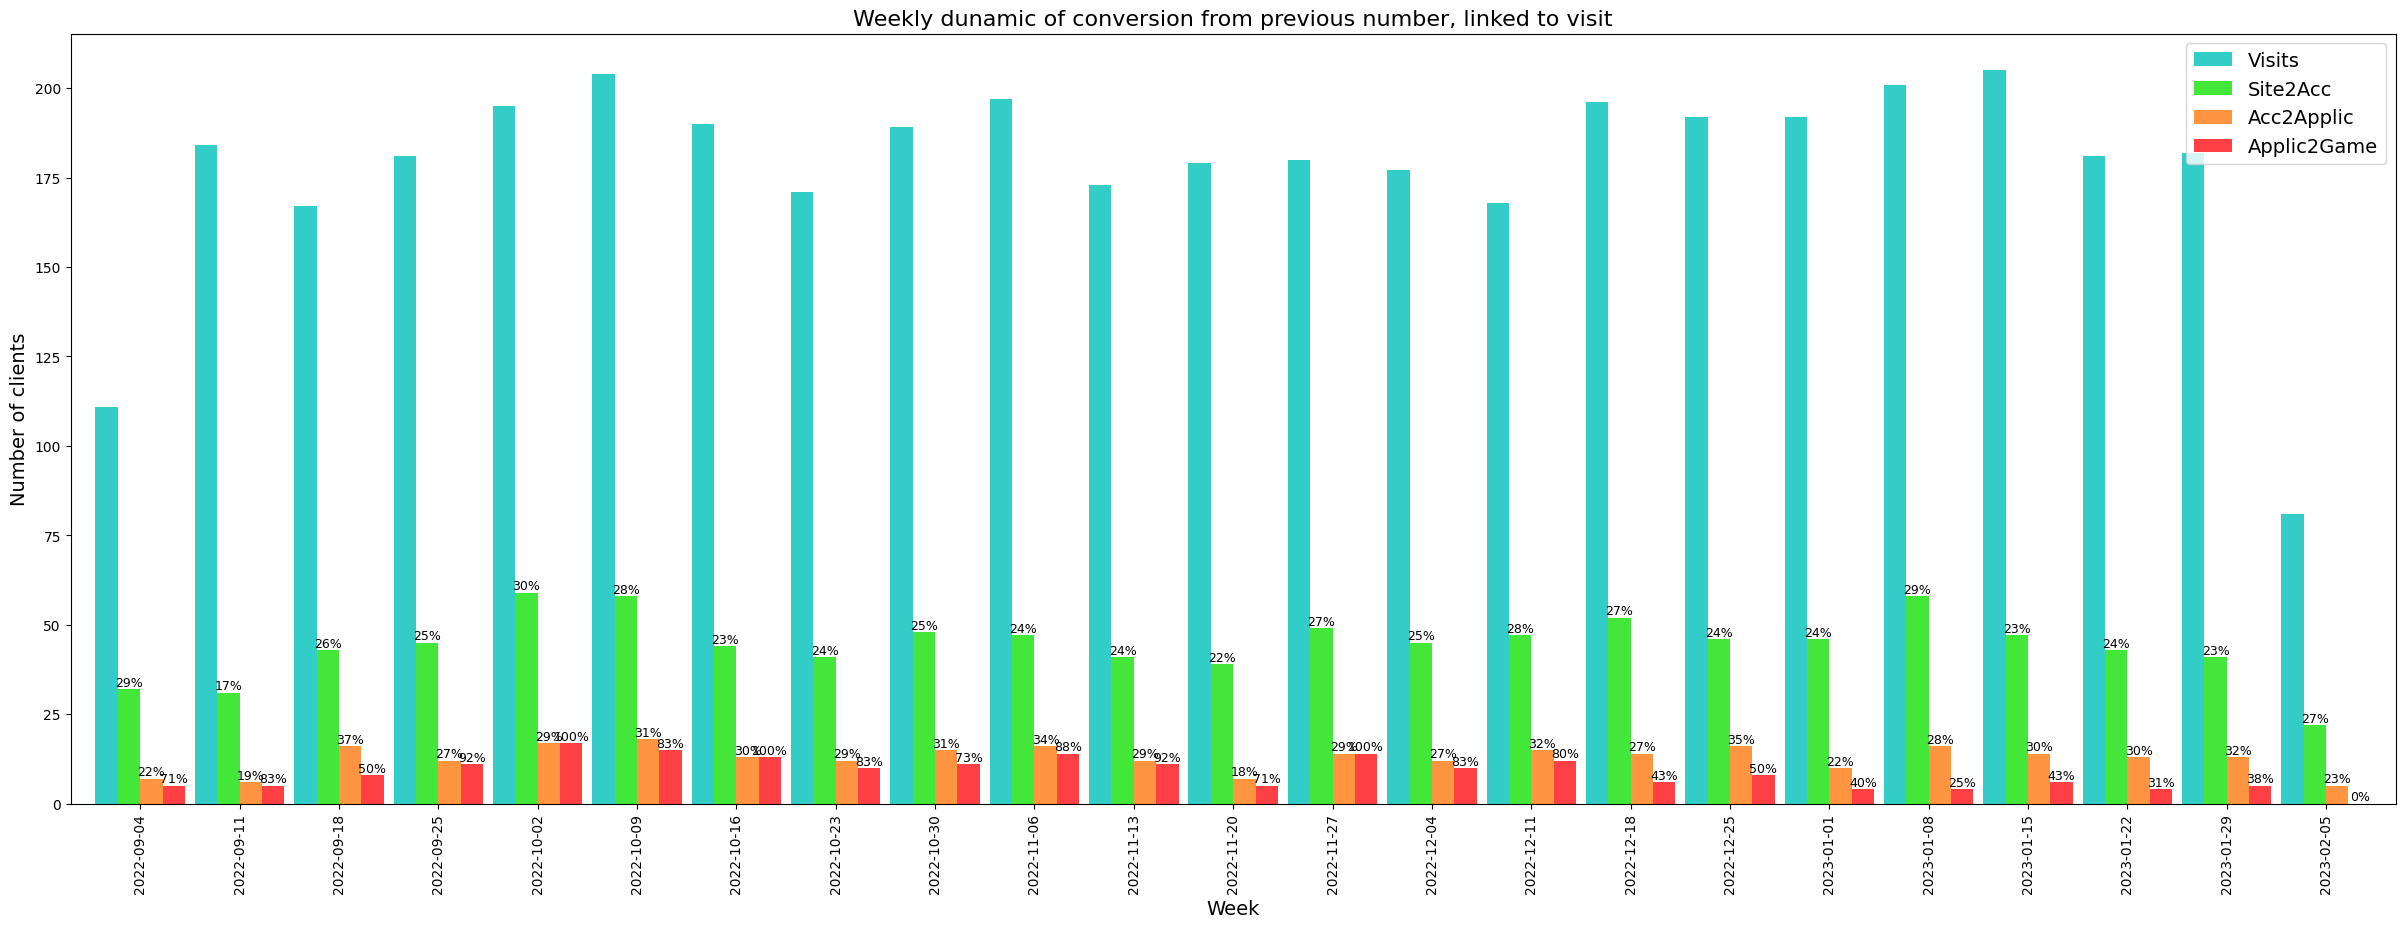

In [58]:
week_conversion_plot = week_conversion_df.plot(kind='bar', figsize=(30, 10), color = week_colors_list, width = 0.9)
week_conversion_plot.set_xticklabels([i.strftime('%Y-%m-%d') for i in week_conversion_df.index])
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Weekly dunamic of conversion from previous number, linked to visit", fontsize= 16)
plt.legend(['Visits', 'Site2Acc', 'Acc2Applic', 'Applic2Game'], fontsize=14)
plt.xticks(rotation=90)

heights = [j.get_height() for i in week_conversion_plot.containers for j in i]
for i in range(3):
  cont = week_conversion_plot.containers[i + 1]
  week_conversion_plot.bar_label(cont, label_type='edge', fontsize=9,
                                 labels=[f'{cont[j].get_height() / heights[j + len(cont) * i]:.0%}' for j in range(len(cont))])
plt.show()

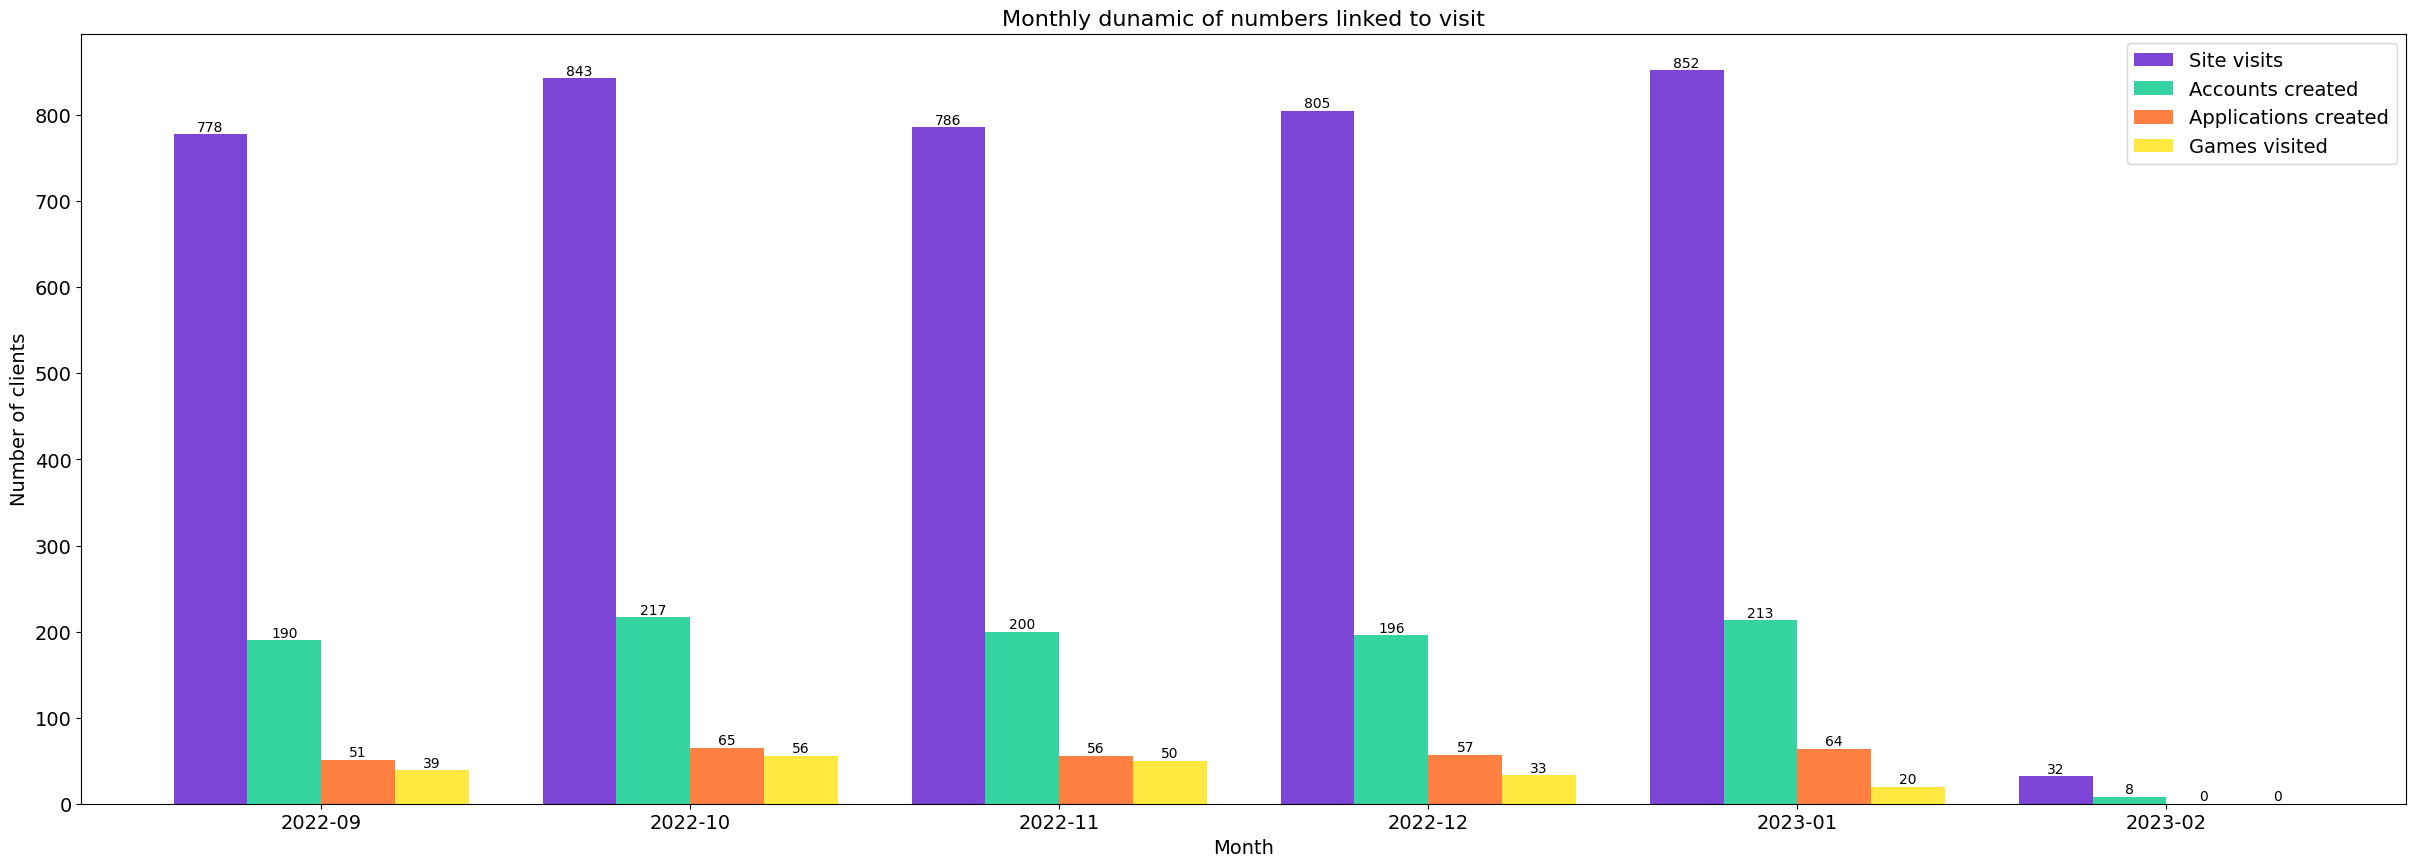

In [63]:
month_conversion_plot = month_conversion_df.plot(kind='bar', figsize=(30, 10), color = month_colors_list, width = 0.8, fontsize = 14)
month_conversion_plot.set_xticklabels([i.strftime('%Y-%m') for i in month_conversion_df.index])
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Monthly dunamic of numbers linked to visit", fontsize= 16)
plt.legend(['Site visits', 'Accounts created', 'Applications created', 'Games visited'], fontsize=14)
plt.xticks(rotation=0)

for cont in month_conversion_plot.containers:
    month_conversion_plot.bar_label(cont, label_type='edge', fontsize=10, labels=[f'{j.get_height()}' for j in cont])
plt.show()

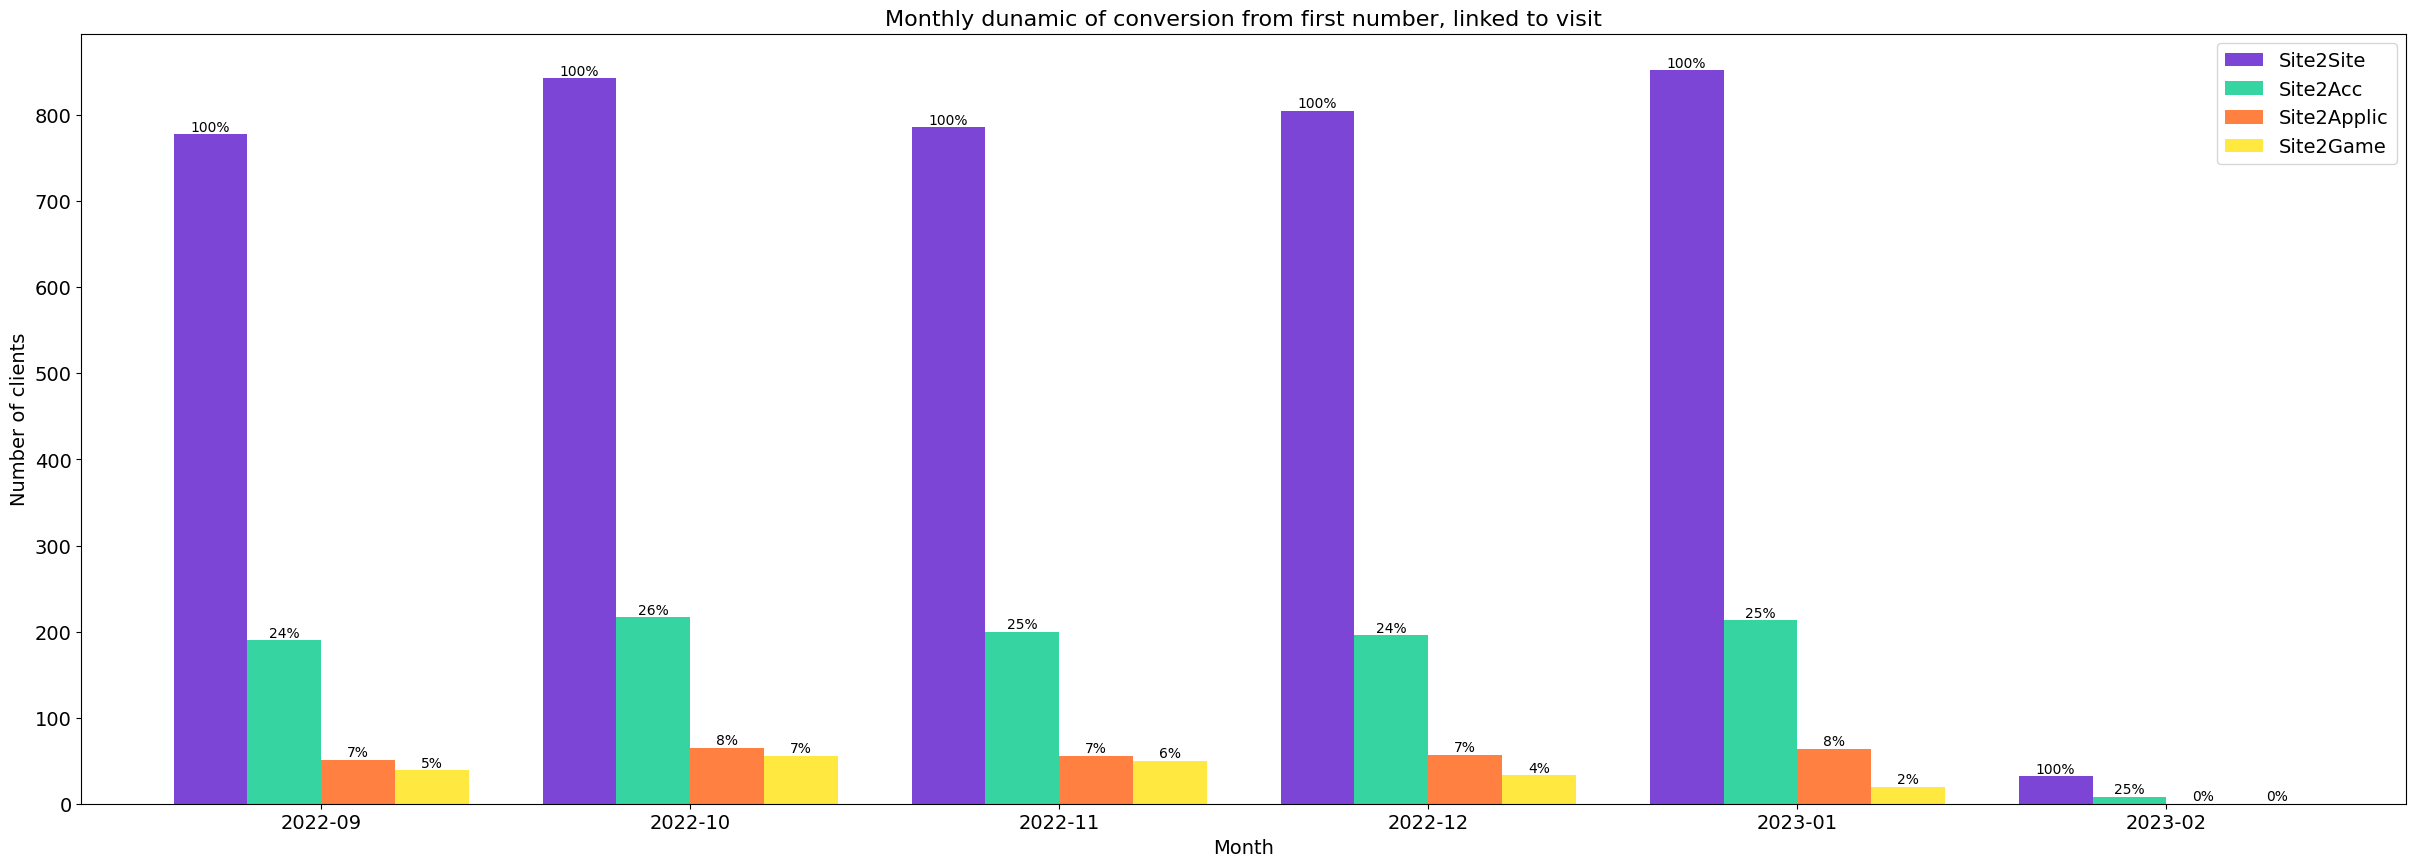

In [60]:
month_conversion_plot = month_conversion_df.plot(kind='bar', figsize=(30, 10), color = month_colors_list, width = 0.8, fontsize = 14)
month_conversion_plot.set_xticklabels([i.strftime('%Y-%m') for i in month_conversion_df.index])
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Monthly dunamic of conversion from first number, linked to visit", fontsize= 16)
plt.legend(['Site2Site', 'Site2Acc', 'Site2Applic', 'Site2Game'], fontsize=14)
plt.xticks(rotation=0)

heights = [i.get_height() for i in month_conversion_plot.containers[0]]
for cont in month_conversion_plot.containers:
  month_conversion_plot.bar_label(cont, label_type='edge', fontsize=10,
                                 labels=[f'{cont[j].get_height() / heights[j]:.0%}' for j in range(len(cont))])
plt.show()

<ipython-input-64-ebbf1d32cb06>:13: RuntimeWarning: invalid value encountered in long_scalars
  labels=[f'{cont[j].get_height() / heights[j + len(cont) * i]:.0%}' for j in range(len(cont))])


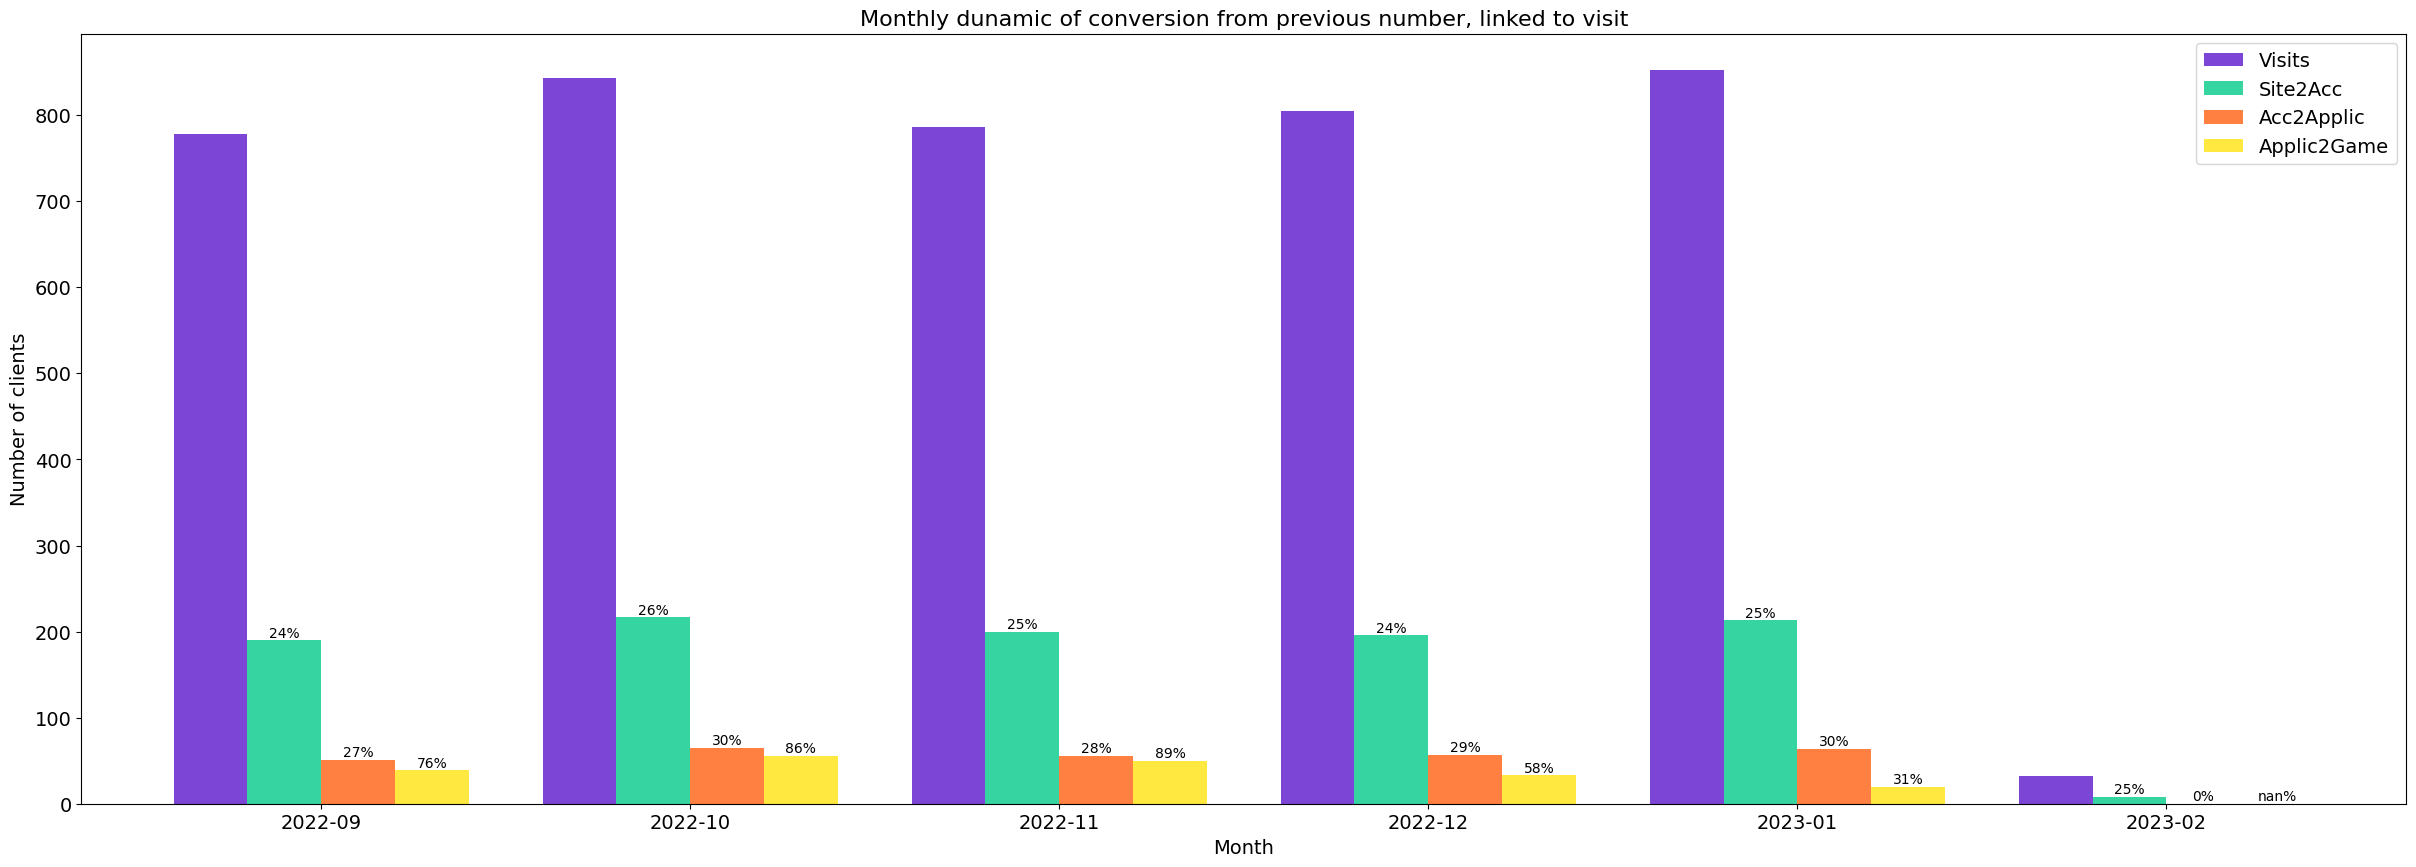

In [64]:
month_conversion_plot = month_conversion_df.plot(kind='bar', figsize=(30, 10), color = month_colors_list, width = 0.8, fontsize = 14)
month_conversion_plot.set_xticklabels([i.strftime('%Y-%m') for i in month_conversion_df.index])
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Monthly dunamic of conversion from previous number, linked to visit", fontsize= 16)
plt.legend(['Visits', 'Site2Acc', 'Acc2Applic', 'Applic2Game'], fontsize=14)
plt.xticks(rotation=0)

heights = [j.get_height() for i in month_conversion_plot.containers for j in i]
for i in range(3):
  cont = month_conversion_plot.containers[i + 1]
  month_conversion_plot.bar_label(cont, label_type='edge', fontsize=10,
                                 labels=[f'{cont[j].get_height() / heights[j + len(cont) * i]:.0%}' for j in range(len(cont))])
plt.show()

Выводы:


1.   Конверсия на последнем этапе довольно высока, хоть и не 100%, особенно у людей в первые месяцы. Это значит, что, если люди записались на квест, то они скорее всего его посетят.
2.   Потери на втором и третьем этапе значительно больше, чем на четвертом, и составляют примерно по 3/4 на каждом. Из этого можно сделать вывод что именно тут есть простор для увеличения количества пользователей
3. Также стоит отметить что количество посещений падает. Так как мы привязали все данные к посещению сайта в первый раз, это говорит скорее всего о том, что люди посещают квест не сразу, что вполне нормально.


# Второй вариант

Теперь рассмотрим просто группировку всех активностей по неделям и месяцам без привязки к перовму визиту пользователя. Проблема этого метода, что мы не убираем повторения в колличестве заявок, а значит конверсия аккаунтов в заявки может быть больше 100%. Если убирать дупликаты то они разобьются по месяцам слишком случайным образом, а значит мы не сможем увидеть динамику корректно

In [48]:
#Группируем каждую таблицу по неделям, а затем переименовываем столбцы для последующего мерджа

week_client_df = client_df.groupby(pd.Grouper(key = 'visit_dttm', freq = 'W')).agg({'phone_num' : 'count'})\
  .reset_index().rename({'phone_num' : 'clients', 'visit_dttm' : 'dttm'}, axis = 1)

week_account_df = account_df.groupby(pd.Grouper(key = 'registration_dttm', freq = 'W')).agg({'account_rk' : 'count'})\
  .reset_index().rename({'account_rk' : 'accounts', 'registration_dttm' : 'dttm'}, axis = 1)

#Здесь не нужно исключать повторения, потому что у нас нет привзяки к пользователю, а значит нам важно общее количество заявок
week_application_df = application_df.groupby(pd.Grouper(key = 'application_dttm', freq = 'W')).agg({'account_rk' : 'count'})\
  .reset_index().rename({'account_rk' : 'applications', 'application_dttm' : 'dttm'}, axis = 1)

week_game_df = game_df.groupby(pd.Grouper(key = 'game_dttm', freq = 'W')).agg({'game_flg' : 'sum'})\
  .reset_index().rename({'game_flg' : 'games', 'game_dttm' : 'dttm'}, axis = 1)

week_conversion2_df = week_client_df.merge(week_account_df, on='dttm', how = 'left')\
                .merge(week_application_df, on='dttm', how = 'left')\
                .merge(week_game_df, on='dttm', how = 'left').set_index('dttm')
week_conversion2_df

,clients,accounts,applications,games
dttm,,,,
2022-09-04,111,22,NaN,NaN
2022-09-11,184,38,7.0,NaN
2022-09-18,167,42,17.0,1.0
2022-09-25,181,46,24.0,1.0
2022-10-02,195,56,18.0,1.0
2022-10-09,204,59,33.0,5.0
2022-10-16,190,46,28.0,3.0
2022-10-23,171,42,24.0,5.0
2022-10-30,189,48,18.0,7.0


In [49]:
#Отдельно считаем месяца
month_client_df = client_df.groupby(pd.Grouper(key = 'visit_dttm', freq = 'M')).agg({'phone_num' : 'count'})\
  .reset_index().rename({'phone_num' : 'clients', 'visit_dttm' : 'dttm'}, axis = 1)

month_account_df = account_df.groupby(pd.Grouper(key = 'registration_dttm', freq = 'M')).agg({'account_rk' : 'count'})\
  .reset_index().rename({'account_rk' : 'accounts', 'registration_dttm' : 'dttm'}, axis = 1)

#Здесь не нужно исключать повторения, потому что у нас нет привзяки к пользователю, а значитнам важно общее количество заявок
month_application_df = application_df.groupby(pd.Grouper(key = 'application_dttm', freq = 'M')).agg({'account_rk' : 'count'})\
  .reset_index().rename({'account_rk' : 'applications', 'application_dttm' : 'dttm'}, axis = 1)

month_game_df = game_df.groupby(pd.Grouper(key = 'game_dttm', freq = 'M')).agg({'game_flg' : 'sum'})\
  .reset_index().rename({'game_flg' : 'games', 'game_dttm' : 'dttm'}, axis = 1)

month_conversion2_df = month_client_df.merge(month_account_df, on='dttm', how = 'left')\
                .merge(month_application_df, on='dttm', how = 'left')\
                .merge(month_game_df, on='dttm', how = 'left').set_index('dttm')
month_conversion2_df

,clients,accounts,applications,games
dttm,,,,
2022-09-30,778,186,63,2
2022-10-31,843,219,109,21
2022-11-30,786,195,107,43
2022-12-31,805,200,97,47
2023-01-31,852,215,133,63
2023-02-28,32,9,3,3


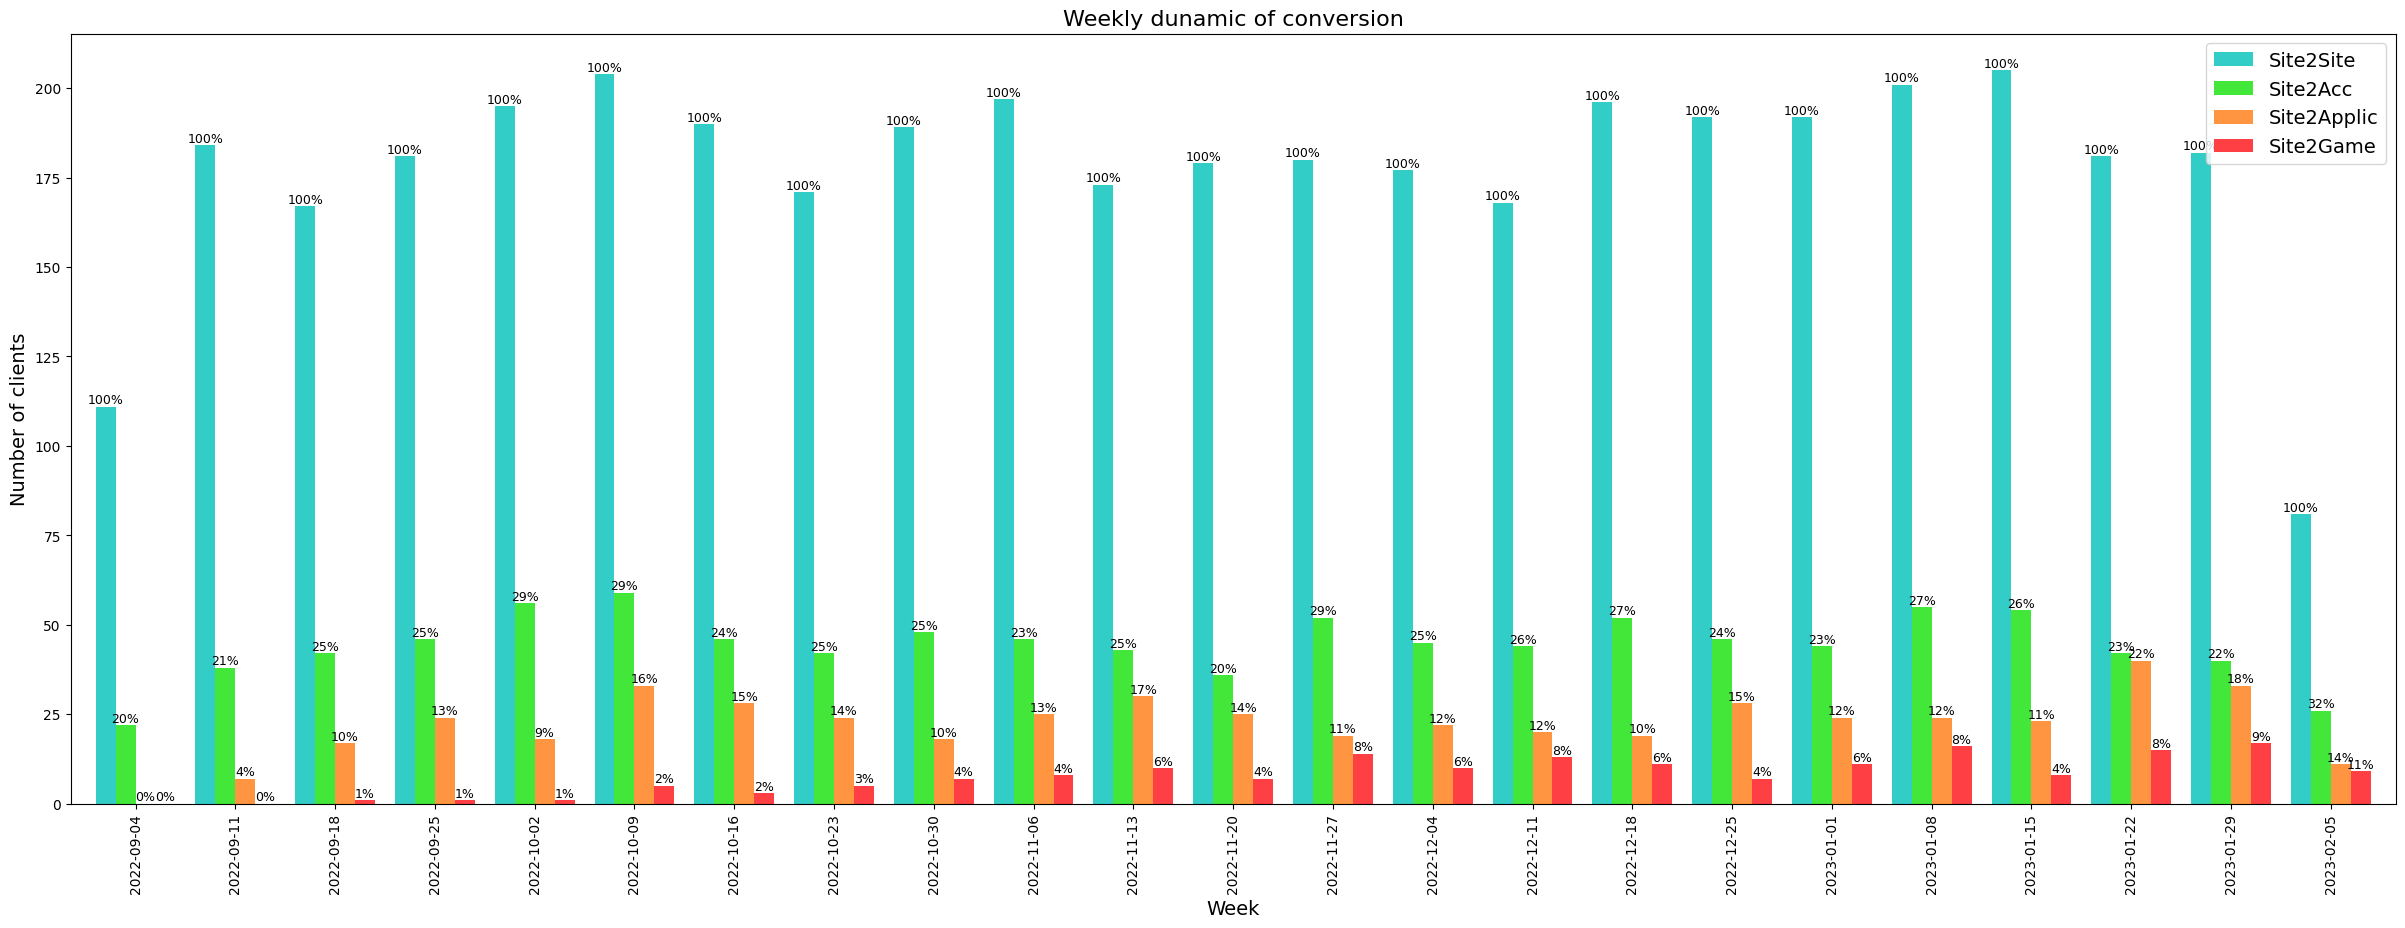

In [50]:
week_conversion2_plot = week_conversion2_df.plot(kind='bar', figsize=(30, 10), color = week_colors_list, width = 0.8)
week_conversion2_plot.set_xticklabels([i.strftime('%Y-%m-%d') for i in week_conversion2_df.index])
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Weekly dunamic of conversion from first number", fontsize= 16)
plt.legend(['Site2Site', 'Site2Acc', 'Site2Applic', 'Site2Game'], fontsize=14)
plt.xticks(rotation=90)

heights = [i.get_height() for i in week_conversion2_plot.containers[0]]
for cont in week_conversion2_plot.containers:
  week_conversion2_plot.bar_label(cont, label_type='edge', fontsize=9,
                                 labels=[f'{cont[j].get_height() / heights[j]:.0%}' for j in range(len(cont))])
plt.show()

<ipython-input-51-db00a34fcd76>:13: RuntimeWarning: invalid value encountered in double_scalars
  labels=[f'{cont[j].get_height() / heights[j + len(cont) * i]:.0%}' for j in range(len(cont))])


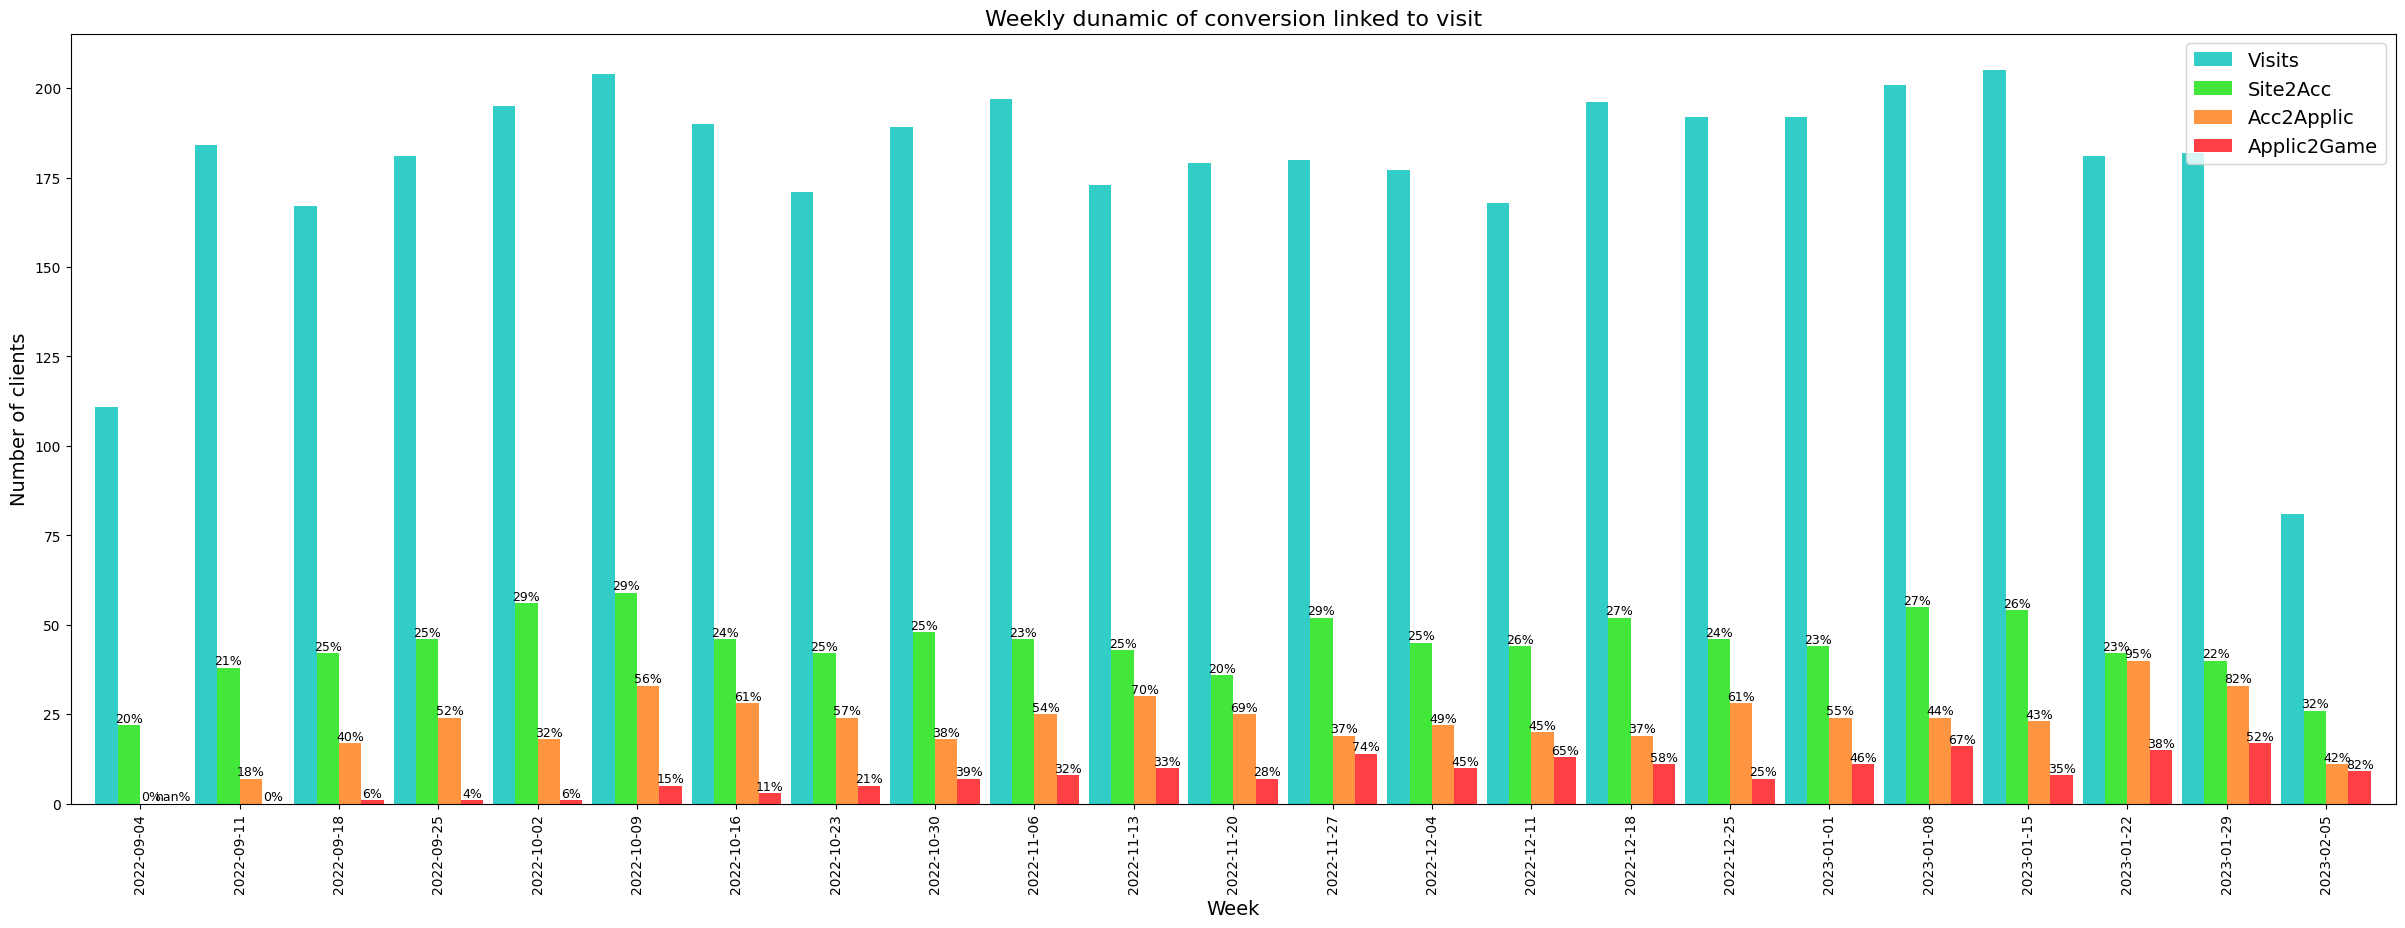

In [51]:
week_conversion2_plot = week_conversion2_df.plot(kind='bar', figsize=(30, 10), color = week_colors_list, width = 0.9)
week_conversion2_plot.set_xticklabels([i.strftime('%Y-%m-%d') for i in week_conversion2_df.index])
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Weekly dunamic of conversion from previous number, linked to visit", fontsize= 16)
plt.legend(['Visits', 'Site2Acc', 'Acc2Applic', 'Applic2Game'], fontsize=14)
plt.xticks(rotation=90)

heights = [j.get_height() for i in week_conversion2_plot.containers for j in i]
for i in range(3):
  cont = week_conversion2_plot.containers[i + 1]
  week_conversion2_plot.bar_label(cont, label_type='edge', fontsize=9,
                                 labels=[f'{cont[j].get_height() / heights[j + len(cont) * i]:.0%}' for j in range(len(cont))])
plt.show()

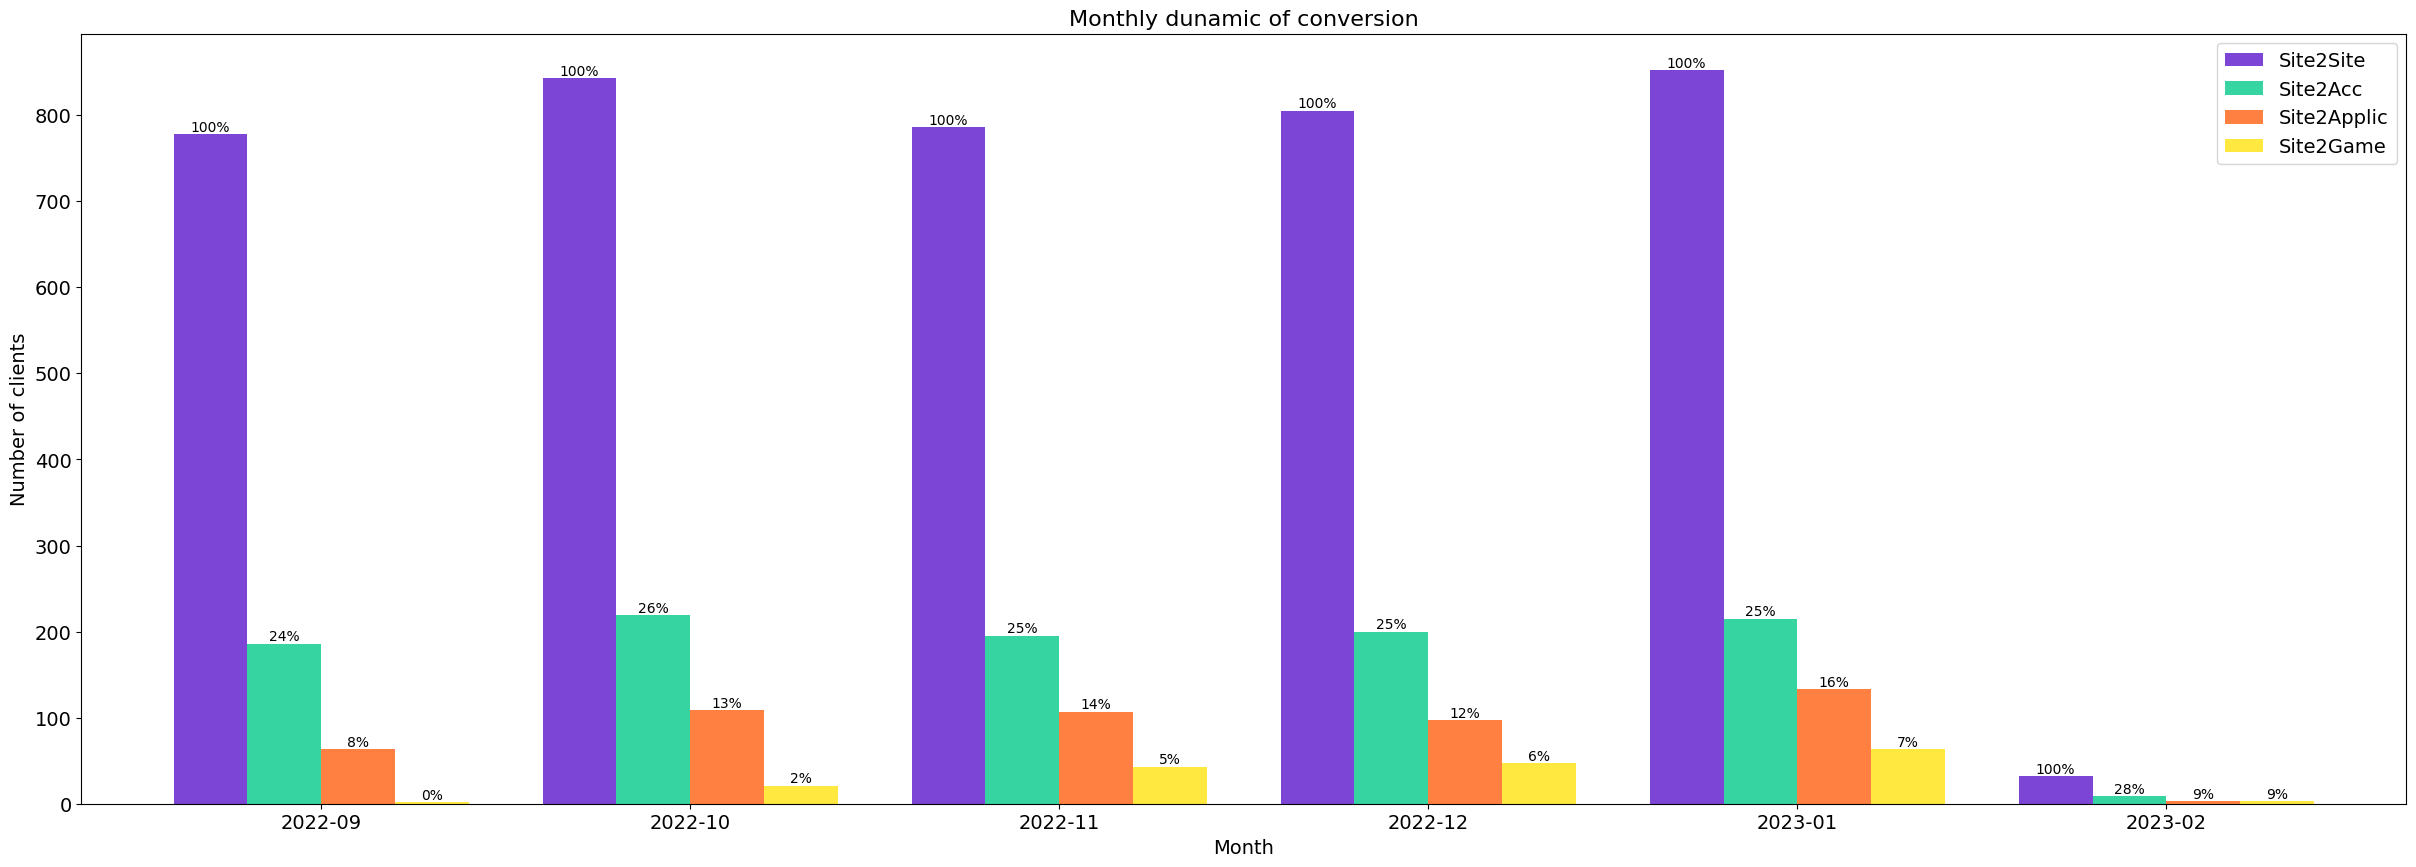

In [52]:
month_conversion2_plot = month_conversion2_df.plot(kind='bar', figsize=(30, 10), color = month_colors_list, width = 0.8, fontsize = 14)
month_conversion2_plot.set_xticklabels([i.strftime('%Y-%m') for i in month_conversion2_df.index])
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Monthly dunamic of conversion from first number", fontsize= 16)
plt.legend(['Site2Site', 'Site2Acc', 'Site2Applic', 'Site2Game'], fontsize=14)
plt.xticks(rotation=0)

heights = [i.get_height() for i in month_conversion2_plot.containers[0]]
for cont in month_conversion2_plot.containers:
  month_conversion2_plot.bar_label(cont, label_type='edge', fontsize=10,
                                 labels=[f'{cont[j].get_height() / heights[j]:.0%}' for j in range(len(cont))])
plt.show()

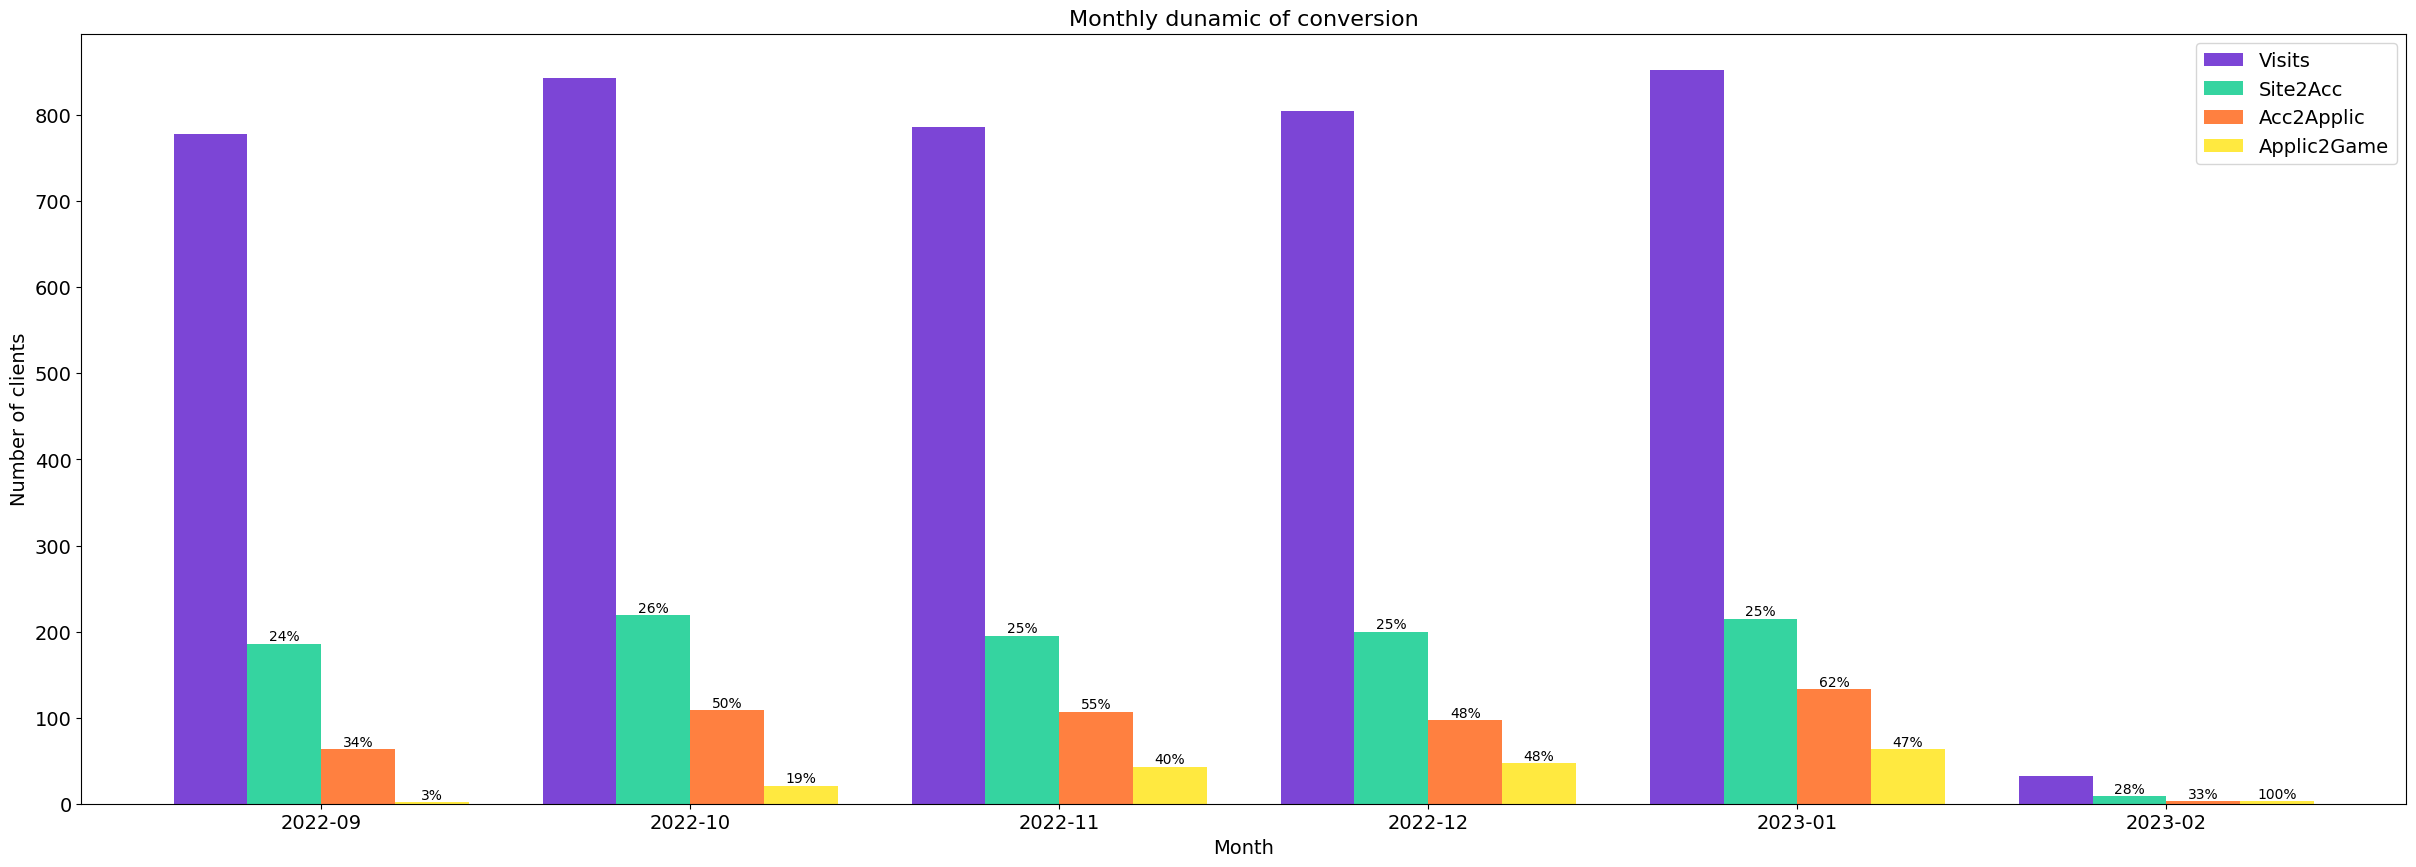

In [53]:
month_conversion2_plot = month_conversion2_df.plot(kind='bar', figsize=(30, 10), color = month_colors_list, width = 0.8, fontsize = 14)
month_conversion2_plot.set_xticklabels([i.strftime('%Y-%m') for i in month_conversion2_df.index])
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of clients', fontsize=14)
plt.title("Monthly dunamic of conversion from previous number", fontsize= 16)
plt.legend(['Visits', 'Site2Acc', 'Acc2Applic', 'Applic2Game'], fontsize=14)
plt.xticks(rotation=0)

heights = [j.get_height() for i in month_conversion2_plot.containers for j in i]
for i in range(3):
  cont = month_conversion2_plot.containers[i + 1]
  month_conversion2_plot.bar_label(cont, label_type='edge', fontsize=10,
                                 labels=[f'{cont[j].get_height() / heights[j + len(cont) * i]:.0%}' for j in range(len(cont))])
plt.show()

Выводы:

1.   Теперь можно заметить, что посещение игр растет, в отличие от первого вариант. Это связано с накопительным эффектом, когда пользователи с прошлых месяцев или недель идут позднее
2.  Также можно увидеть, что количество заявок выросло, причина этого в том, что мы не убирали повторы.
3.  Данные по конверсии в аккаунты также остались на уровне в 25%



# Итоговые выводы



1.   Можно утвержать, что если пользователь создал заявку, то он, скорее всего,придет на игру, хоть и не гаратировано
2.   Конверсии из посещений в аккаунты и из аккаунтов в заяки примерно равны.
3.   Посещение квестов имеет накопительный эффект, то есть растет со временем.
4.   Главной точкой роста можно назвать превращение аккаунтов в заявки. Т.к. если клиент не создал аккаунт (значит, его это просто не занитересовало), то он просто пропадает из нашего поля зрения. С создавшим же аккаунт можно уже работать основательнее.
5.   Также можно попробовать повысить количество клиентов на первом этапе. Так как конверсии на всех остальных достаточно стабильны, то рост посещений скорее всего приведет к увеличению посещения игр.

